In [1]:
#W1803608 VALID AL-DZHAZZAR
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import statsmodels.api as sm

from sklearn.model_selection import cross_val_score

# Directory containing Excel files
data_dir = '/Users/waleedjazzar/Desktop/Year 3 Uni/Final Year Files/Datasets/MET/boulmer'

# Location 
location = 'boulmer'

#store DataFrames for each year
dfs = []

# Iterate through each year
for year in range(2016, 2021):  # Assuming data is from 2016 to 2020
    filename = f'{location}_{year}.xlsx'
    
    filepath = os.path.join(data_dir, filename)
    if os.path.exists(filepath):
        df = pd.read_excel(filepath)
        dfs.append(df)
    else:
        print(f"Warning: File '{filename}' not found for location '{location}' and year {year}. Skipping...")

# Concatenate DataFrames 
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)

    # Save processed data to a single Excel file
    combined_df = combined_df[combined_df['id_type'] == 'WIND']
    combined_df.to_excel('/Users/waleedjazzar/Desktop/Year 3 Uni/Final Year Files/Datasets/MET/boulmer/combined_boulmer_data.xlsx', index=False)
else:
    print(f"No data found for location '{location}'.")
combined_df = combined_df[combined_df['id_type'] == 'WIND']


In [2]:
print(combined_df.head())

           ob_end_time id_type        id  ob_hour_count met_domain_name  \
0  2016-01-01 00:00:00    WIND  209602.0            1.0             HCM   
1  2016-01-01 01:00:00    WIND  209602.0            1.0             HCM   
2  2016-01-01 02:00:00    WIND  209602.0            1.0             HCM   
3  2016-01-01 03:00:00    WIND  209602.0            1.0             HCM   
4  2016-01-01 04:00:00    WIND  209602.0            1.0             HCM   

   version_num  src_id  rec_st_ind  mean_wind_dir  mean_wind_speed  ...  \
0          1.0   315.0      1011.0          240.0             11.0  ...   
1          1.0   315.0      1011.0          250.0             12.0  ...   
2          1.0   315.0      1011.0          250.0             10.0  ...   
3          1.0   315.0      1011.0          240.0              9.0  ...   
4          1.0   315.0      1011.0          190.0              6.0  ...   

   mean_wind_speed_q  max_gust_dir_q  max_gust_speed_q  max_gust_ctime_q  \
0                6.0  

In [3]:
#CHECK FOR NULL AND SHOW NULL
null_values = combined_df.isnull().any()
# Display the columns with null values
if null_values.any():
    print("Columns with null values:")
    print(null_values[null_values].index)
else:
    print("No null values found.")
null_indexes = combined_df[combined_df.isnull().any(axis=1)].index
print("Indexes of rows containing null values:")
print(null_indexes)


Columns with null values:
Index(['mean_wind_dir', 'mean_wind_speed', 'max_gust_dir', 'max_gust_speed',
       'max_gust_ctime', 'mean_wind_dir_q', 'mean_wind_speed_q',
       'max_gust_dir_q', 'max_gust_speed_q', 'max_gust_ctime_q',
       'mean_wind_dir_j', 'mean_wind_speed_j', 'max_gust_dir_j',
       'max_gust_speed_j', 'midas_stmp_etime'],
      dtype='object')
Indexes of rows containing null values:
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            40794, 40795, 40796, 40797, 40798, 40799, 40800, 40801, 40802,
            40803],
           dtype='int64', length=40800)


In [4]:
#Drop unwanted columns 
columns_to_drop = ['id_type','id','ob_hour_count','met_domain_name','version_num','src_id','rec_st_ind','max_gust_ctime_q','max_gust_speed_q','max_gust_dir_q','mean_wind_speed_q','mean_wind_dir_q','mean_wind_dir_j', 'mean_wind_speed_j', 'max_gust_dir_j', 'max_gust_speed_j','meto_stmp_time','midas_stmp_etime']
combined_df = combined_df.drop(columns=columns_to_drop)
#Display the first few rows 
print(combined_df.head())

           ob_end_time  mean_wind_dir  mean_wind_speed  max_gust_dir  \
0  2016-01-01 00:00:00          240.0             11.0         240.0   
1  2016-01-01 01:00:00          250.0             12.0         250.0   
2  2016-01-01 02:00:00          250.0             10.0         240.0   
3  2016-01-01 03:00:00          240.0              9.0         250.0   
4  2016-01-01 04:00:00          190.0              6.0         220.0   

   max_gust_speed  max_gust_ctime  
0            20.0          2345.0  
1            20.0            40.0  
2            17.0            51.0  
3            18.0           213.0  
4            12.0           347.0  


In [5]:
#CHECK FOR NULL
null_values = combined_df.isnull().any()
if null_values.any():
    print("Columns with null values:")
    print(null_values[null_values].index)
else:
    print("No null values found.")
null_indexes = combined_df[combined_df.isnull().any(axis=1)].index
print("Indexes of rows containing null values:")
print(null_indexes)


Columns with null values:
Index(['mean_wind_dir', 'mean_wind_speed', 'max_gust_dir', 'max_gust_speed',
       'max_gust_ctime'],
      dtype='object')
Indexes of rows containing null values:
Int64Index([ 3363,  8130,  8131,  8132,  8133,  8134,  8135,  8136,  8137,
             8138,
            ...
            34229, 37382, 37383, 37384, 37385, 37386, 37387, 37388, 37389,
            37390],
           dtype='int64', length=781)


In [6]:

combined_df['ob_end_time'] = pd.to_datetime(combined_df['ob_end_time'])
#continuous range of dates/times covering the entire period of interest
start_date = '2016-01-01 00:00:00'
end_date = '2020-12-10 15:00:00'
continuous_range = pd.date_range(start=start_date, end=end_date, freq='H')
# Find missing dates
missing_dates = continuous_range[~continuous_range.isin(combined_df['ob_end_time'])]
if len(missing_dates) == 0:
    print("All hours are present.")
else:
    print("Some hours are missing. Missing dates:")
    print(missing_dates)
missing_dates = continuous_range[~continuous_range.isin(combined_df['ob_end_time'])]
#DataFrame from the missing dates
missing_dates_df = pd.DataFrame({'Missing Dates': missing_dates})
print(missing_dates_df)


Some hours are missing. Missing dates:
DatetimeIndex(['2016-02-16 15:00:00', '2016-02-16 16:00:00',
               '2016-02-16 17:00:00', '2016-04-06 10:00:00',
               '2016-04-06 11:00:00', '2016-04-06 12:00:00',
               '2016-04-06 13:00:00', '2016-04-06 19:00:00',
               '2016-04-06 20:00:00', '2016-04-06 21:00:00',
               ...
               '2020-02-14 01:00:00', '2020-02-14 02:00:00',
               '2020-02-14 03:00:00', '2020-02-14 04:00:00',
               '2020-02-14 05:00:00', '2020-02-14 06:00:00',
               '2020-02-14 07:00:00', '2020-02-14 08:00:00',
               '2020-02-14 09:00:00', '2020-09-21 08:00:00'],
              dtype='datetime64[ns]', length=2536, freq=None)
           Missing Dates
0    2016-02-16 15:00:00
1    2016-02-16 16:00:00
2    2016-02-16 17:00:00
3    2016-04-06 10:00:00
4    2016-04-06 11:00:00
...                  ...
2531 2020-02-14 06:00:00
2532 2020-02-14 07:00:00
2533 2020-02-14 08:00:00
2534 2020-02-14 09:

In [7]:
# Fill in the missing hours by reindexing the DataFrame with the continuous range of dates/times
combined_df_filled = combined_df.set_index('ob_end_time').reindex(continuous_range).reset_index()
print(combined_df_filled.head())

                index  mean_wind_dir  mean_wind_speed  max_gust_dir  \
0 2016-01-01 00:00:00          240.0             11.0         240.0   
1 2016-01-01 01:00:00          250.0             12.0         250.0   
2 2016-01-01 02:00:00          250.0             10.0         240.0   
3 2016-01-01 03:00:00          240.0              9.0         250.0   
4 2016-01-01 04:00:00          190.0              6.0         220.0   

   max_gust_speed  max_gust_ctime  
0            20.0          2345.0  
1            20.0            40.0  
2            17.0            51.0  
3            18.0           213.0  
4            12.0           347.0  


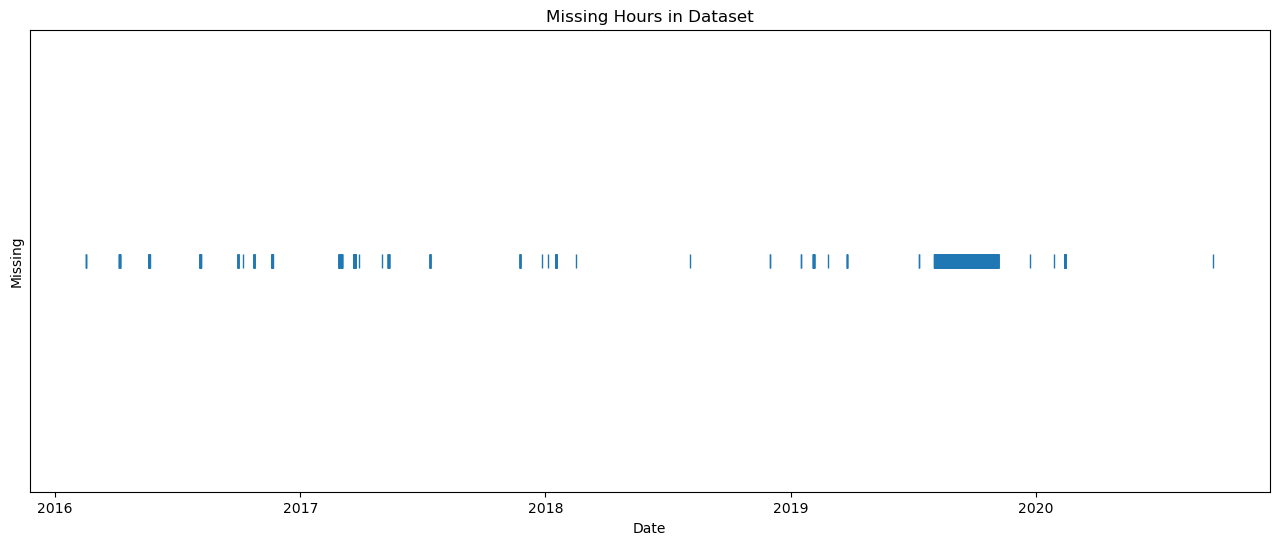

Percentage of missing data using missing hours: 5.85%
Percentage of missing values for each attribute:
index              0.000000
mean_wind_dir      7.649529
mean_wind_speed    7.654144
max_gust_dir       7.296474
max_gust_speed     7.294167
max_gust_ctime     7.294167
dtype: float64


In [8]:

# Plotting the missing dates
plt.figure(figsize=(16, 6))
plt.plot(missing_dates_df['Missing Dates'], [1] * len(missing_dates_df), '|', markersize=10)
plt.title('Missing Hours in Dataset')
plt.xlabel('Date')
plt.ylabel('Missing')
plt.yticks([])
plt.show()
# Calculate the percentage of missing data using missing dates compared to the whole dataset
percentage_missing_dates = len(missing_dates_df) / len(continuous_range) * 100
print(f"Percentage of missing data using missing hours: {percentage_missing_dates:.2f}%")
# Calculate the percentage of missing values for each attribute
missing_percentage = combined_df.isnull().mean() * 100
missing_percentage_total = combined_df_filled.isnull().mean() * 100
print("Percentage of missing values for each attribute:")
print(missing_percentage_total)


In [9]:
null_values = combined_df_filled.isnull().any()
#columns with null values,
if null_values.any():
    print("Columns with null values:")
    print(null_values[null_values].index)
else:
    print("No null values found.")
null_indexes = combined_df_filled[combined_df_filled.isnull().any(axis=1)].index
print("Indexes of rows containing null values:")
print(null_indexes)

Columns with null values:
Index(['mean_wind_dir', 'mean_wind_speed', 'max_gust_dir', 'max_gust_speed',
       'max_gust_ctime'],
      dtype='object')
Indexes of rows containing null values:
Int64Index([ 1119,  1120,  1121,  2314,  2315,  2316,  2317,  2323,  2324,
             2325,
            ...
            39913, 39914, 39915, 39916, 39917, 39918, 39919, 39920, 39921,
            41408],
           dtype='int64', length=3317)


In [10]:
#new DataFrame without missing values
Wind_Clean = combined_df_filled.dropna()
# Check the shape
print("Size of Wind_Clean:", Wind_Clean.shape)
print(Wind_Clean.head())


Size of Wind_Clean: (40019, 6)
                index  mean_wind_dir  mean_wind_speed  max_gust_dir  \
0 2016-01-01 00:00:00          240.0             11.0         240.0   
1 2016-01-01 01:00:00          250.0             12.0         250.0   
2 2016-01-01 02:00:00          250.0             10.0         240.0   
3 2016-01-01 03:00:00          240.0              9.0         250.0   
4 2016-01-01 04:00:00          190.0              6.0         220.0   

   max_gust_speed  max_gust_ctime  
0            20.0          2345.0  
1            20.0            40.0  
2            17.0            51.0  
3            18.0           213.0  
4            12.0           347.0  


/var/folders/6r/2nrcfqbx669gydmwvq5cyd5h0000gn/T/ipykernel_61326/41885308.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Wind_Clean['year'] = Wind_Clean['index'].dt.year


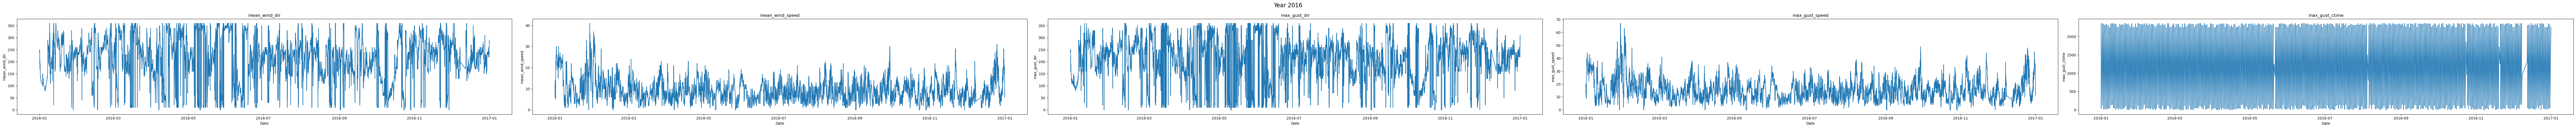

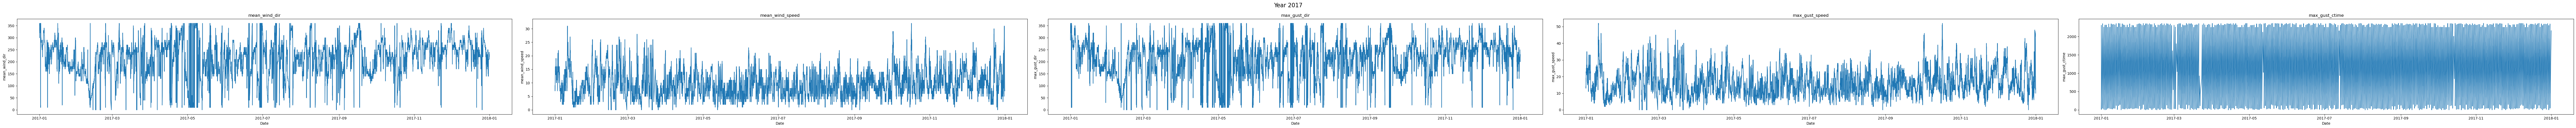

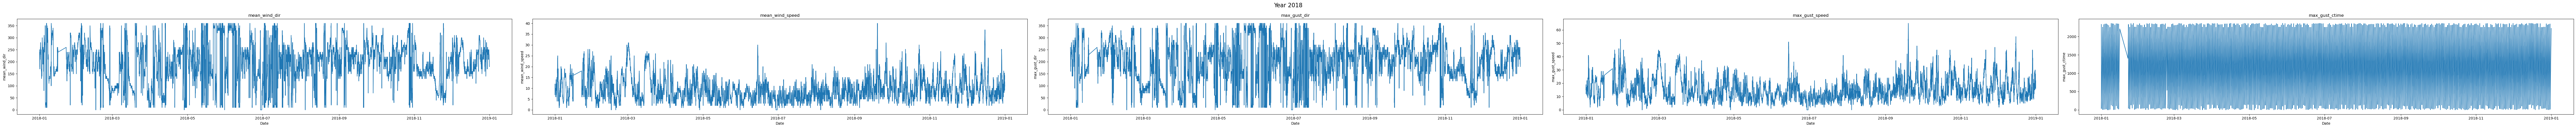

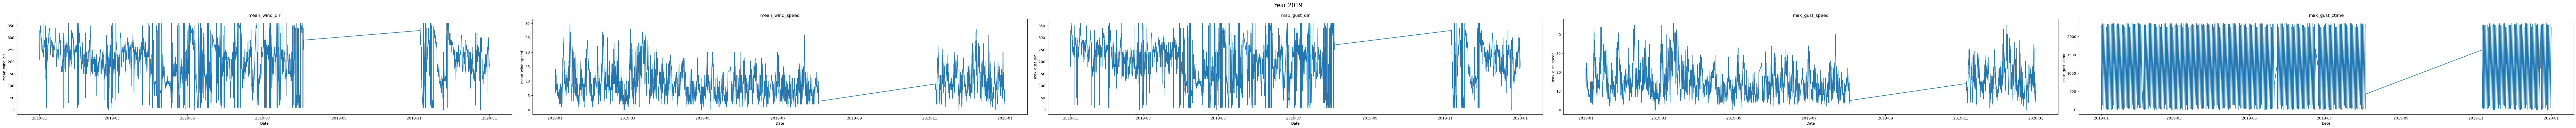

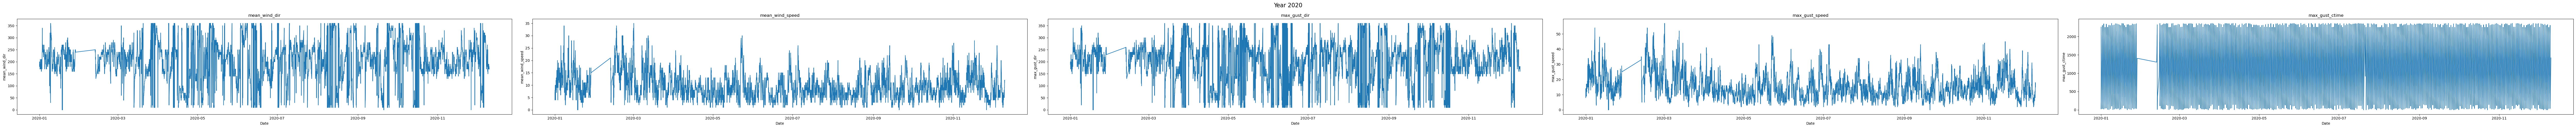

In [11]:
#extract year 
Wind_Clean['year'] = Wind_Clean['index'].dt.year

# Iterate over each year and plot line charts for each variable
for year in sorted(Wind_Clean['year'].unique()):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(100, 5))
    fig.suptitle(f'Year {year}', fontsize=16)
    df_year = Wind_Clean[Wind_Clean['year'] == year]
    # Plot line charts for each variable
    for i, col in enumerate(['mean_wind_dir', 'mean_wind_speed', 'max_gust_dir', 'max_gust_speed', 'max_gust_ctime']):
        ax = axes[i]
        ax.plot(df_year['index'], df_year[col])
        ax.set_title(col)
        ax.set_xlabel('Date')
        ax.set_ylabel(col)
    plt.tight_layout()
    plt.show()


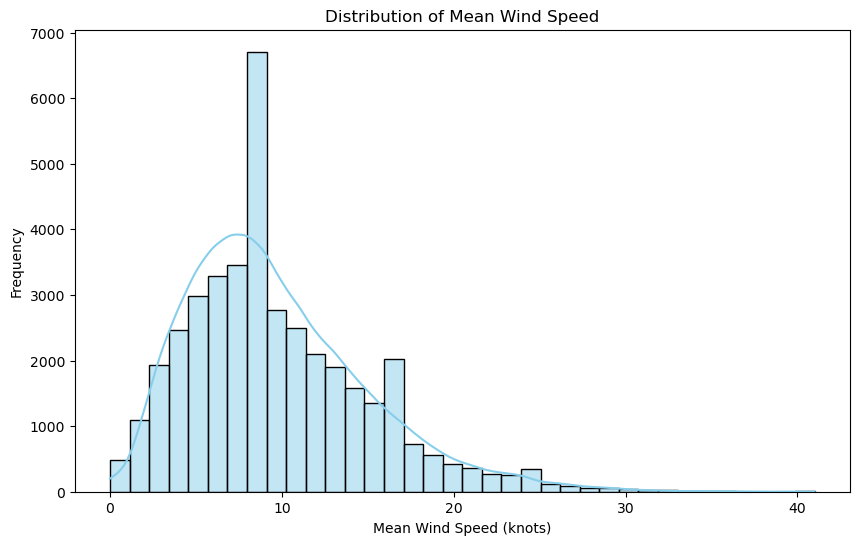

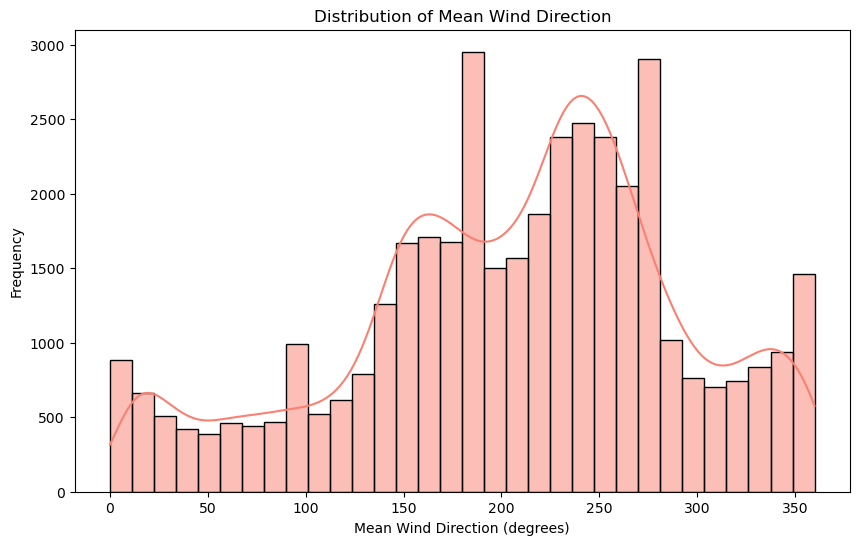

In [12]:
# Plot histogram of mean_wind_speed
plt.figure(figsize=(10, 6))
sns.histplot(Wind_Clean['mean_wind_speed'], bins=36, kde=True, color='skyblue')
plt.title('Distribution of Mean Wind Speed')
plt.xlabel('Mean Wind Speed (knots)')
plt.ylabel('Frequency')
plt.show()
# Plot histogram of mean_wind_dir
plt.figure(figsize=(10, 6))
sns.histplot(Wind_Clean['mean_wind_dir'], bins=32, kde=True, color='salmon')
plt.title('Distribution of Mean Wind Direction')
plt.xlabel('Mean Wind Direction (degrees)')
plt.ylabel('Frequency')
plt.show()

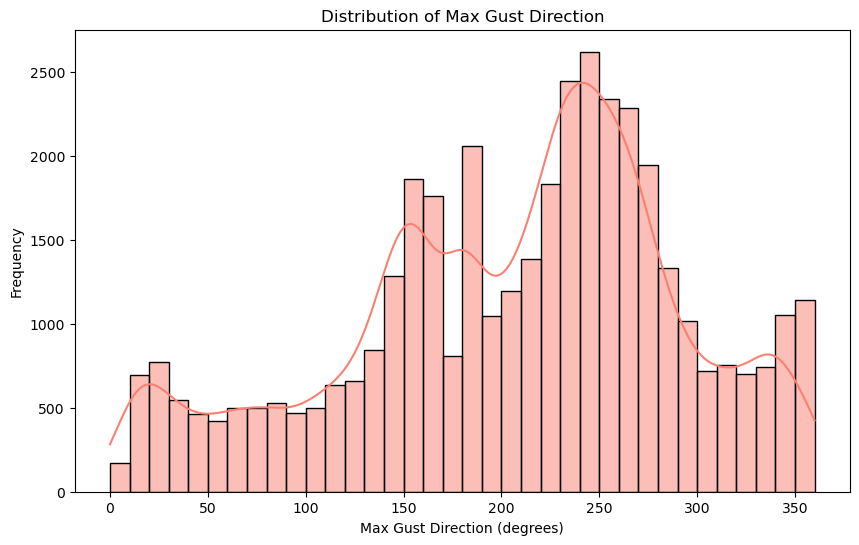

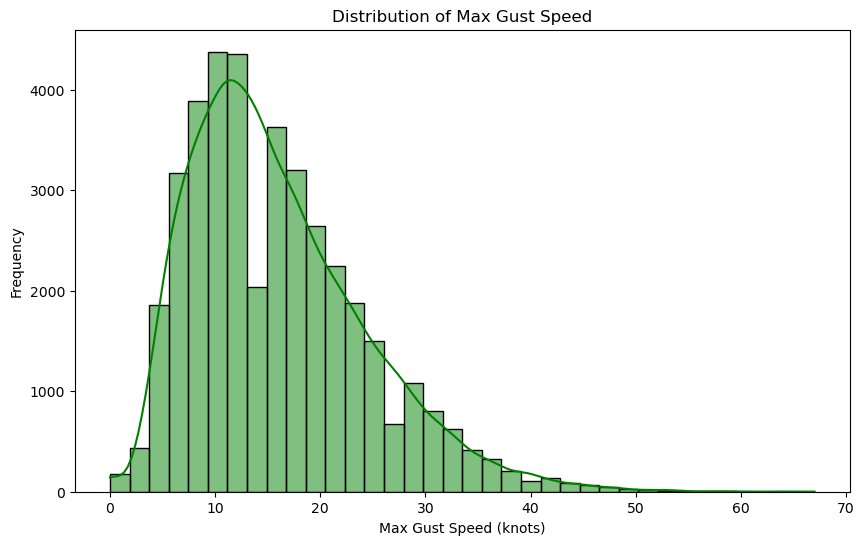

In [13]:
# Plot histogram of max_gust_dir
plt.figure(figsize=(10, 6))
sns.histplot(Wind_Clean['max_gust_dir'], bins=36, kde=True, color='salmon')
plt.title('Distribution of Max Gust Direction')
plt.xlabel('Max Gust Direction (degrees)')
plt.ylabel('Frequency')
plt.show()
# Plot histogram of max_gust_speed
plt.figure(figsize=(10, 6))
sns.histplot(Wind_Clean['max_gust_speed'], bins=36, kde=True, color='green')
plt.title('Distribution of Max Gust Speed')
plt.xlabel('Max Gust Speed (knots)')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Selecting only 'index' and 'mean_wind_speed' columns
Wind_Clean = Wind_Clean[['index', 'mean_wind_speed']]

# Check the shape and first few rows
print("Size of Wind_Clean", Wind_Clean.shape)
print(Wind_Clean.head())


Size of Wind_Clean (40019, 2)
                index  mean_wind_speed
0 2016-01-01 00:00:00             11.0
1 2016-01-01 01:00:00             12.0
2 2016-01-01 02:00:00             10.0
3 2016-01-01 03:00:00              9.0
4 2016-01-01 04:00:00              6.0


In [15]:
#LSTM FEATURES SEASONAL,AND WIND SPEED.
Wind_Clean['index'] = pd.to_datetime(Wind_Clean['index'])
Wind_Clean.set_index('index', inplace=True)  # Setting 'index' as the DataFrame index
# Adding a seasonal feature
Wind_Clean['season'] = Wind_Clean.index.month % 12 // 3 + 1
# Scaling
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(Wind_Clean[['mean_wind_speed', 'season']])
# Splitting
train_data, test_data = train_test_split(scaled_features, test_size=0.4, random_state=42, shuffle=False)
# Generating data for LSTM
n_input = 48
n_features = train_data.shape[1]
train_generator = TimeseriesGenerator(train_data, train_data[:, 0], length=n_input, batch_size=40)
test_generator = TimeseriesGenerator(test_data, test_data[:, 0], length=n_input, batch_size=40)
# LSTM Model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(n_input, n_features)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
# Training
model.fit(train_generator, epochs=30)
# Prediction
predicted = []
for i in range(len(test_generator)):
    x, _ = test_generator[i]
    y_pred = model.predict(x)
    predicted.append(y_pred)

predicted = np.concatenate(predicted)
predicted = scaler.inverse_transform(np.column_stack((predicted, np.zeros((predicted.shape[0], n_features - 1)))))
# Evaluation
true_values = scaler.inverse_transform(test_data[n_input:, :])[:, 0]
mse = mean_squared_error(true_values, predicted[:, 0])
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values, predicted[:, 0])
r2 = r2_score(true_values, predicted[:, 0])
print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')
print(f'Test R2: {r2}')
# Correctly align time index for the predictions
prediction_dates = Wind_Clean.index[len(train_data)+n_input:len(train_data)+n_input+len(predicted)]
predicted_df = pd.DataFrame(data=predicted[:, 0], index=prediction_dates, columns=['Predicted Wind Speed'])

# Joining with the actual values for visualization
actual_data = Wind_Clean['mean_wind_speed'][len(train_data)+n_input:len(train_data)+n_input+len(predicted)]
comparison_df = pd.concat([actual_data, predicted_df], axis=1)

Epoch 1/30


/Users/waleedjazzar/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 16/600 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0748

/Users/waleedjazzar/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0142
Epoch 2/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0034
Epoch 3/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0027
Epoch 4/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0025
Epoch 5/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0024
Epoch 6/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0023
Epoch 7/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0027
Epoch 8/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0024
Epoch 9/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0025
Epoch 10/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0024
Epoch 11/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0025
Epoch 12/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0024
Epoch 13/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0024
Epoch 14/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0025
Epoch 15/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step 

In [ ]:
#LSTM FEATURES SEASONAL, 1-3PERIOD LAG, AND WIND SPEED.

Wind_Clean['index'] = pd.to_datetime(Wind_Clean['index'])
Wind_Clean.set_index('index', inplace=True)  # Setting 'index' as the DataFrame index

# seasonal feature
Wind_Clean['season'] = Wind_Clean.index.month % 12 // 3 + 1

#  lagged wind speeds for the 3 previous hours
for i in range(1, 4):
    Wind_Clean[f'lag_{i}_hour'] = Wind_Clean['mean_wind_speed'].shift(i)

# Drop any rows with NaN values 
Wind_Clean.dropna(inplace=True)
# Scaling
scaler = MinMaxScaler()
features_to_scale = ['mean_wind_speed', 'season'] + [f'lag_{i}_hour' for i in range(1, 4)]
scaled_features = scaler.fit_transform(Wind_Clean[features_to_scale])
# Splitting
train_data, test_data = train_test_split(scaled_features, test_size=0.4, random_state=42, shuffle=False)
# Generating data for LSTM
n_input = 48
n_features = train_data.shape[1]
train_generator = TimeseriesGenerator(train_data, train_data[:, 0], length=n_input, batch_size=40)
test_generator = TimeseriesGenerator(test_data, test_data[:, 0], length=n_input, batch_size=40)
# LSTM Model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(n_input, n_features)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
# Training
model.fit(train_generator, epochs=30)
# Prediction
predicted = []
for i in range(len(test_generator)):
    x, _ = test_generator[i]
    y_pred = model.predict(x)
    predicted.append(y_pred)
predicted = np.concatenate(predicted)
predicted = scaler.inverse_transform(np.column_stack((predicted, np.zeros((predicted.shape[0], n_features - 1)))))
# Evaluation
true_values = scaler.inverse_transform(test_data[n_input:, :])[:, 0]
mse = mean_squared_error(true_values, predicted[:, 0])
rmse = np.sqrt(mse)
mae = mean_absolute_error(true_values, predicted[:, 0])
r2 = r2_score(true_values, predicted[:, 0])
print(f'Test MSE: {mse}')
print(f'Test RMSE: {rmse}')
print(f'Test MAE: {mae}')
print(f'Test R2: {r2}')
#  align time index for the predictions
prediction_dates = Wind_Clean.index[len(train_data)+n_input:len(train_data)+n_input+len(predicted)]

predicted_df = pd.DataFrame(data=predicted[:, 0], index=prediction_dates, columns=['Predicted Wind Speed'])

# Joining with the actual values for visualization
actual_data = Wind_Clean['mean_wind_speed'][len(train_data)+n_input:len(train_data)+n_input+len(predicted)]
comparison_df = pd.concat([actual_data, predicted_df], axis=1)



In [16]:
print(Wind_Clean.head())

                     mean_wind_speed  season
index                                       
2016-01-01 00:00:00             11.0       1
2016-01-01 01:00:00             12.0       1
2016-01-01 02:00:00             10.0       1
2016-01-01 03:00:00              9.0       1
2016-01-01 04:00:00              6.0       1


In [17]:
print(predicted_df)

                     Predicted Wind Speed
index                                    
2018-10-19 19:00:00              8.058612
2018-10-19 20:00:00              7.272577
2018-10-19 21:00:00              6.196115
2018-10-19 22:00:00              7.024681
2018-10-19 23:00:00              5.939479
...                                   ...
2020-12-10 11:00:00              8.586586
2020-12-10 12:00:00              8.610055
2020-12-10 13:00:00             11.740033
2020-12-10 14:00:00             10.462464
2020-12-10 15:00:00             11.578704

[15960 rows x 1 columns]


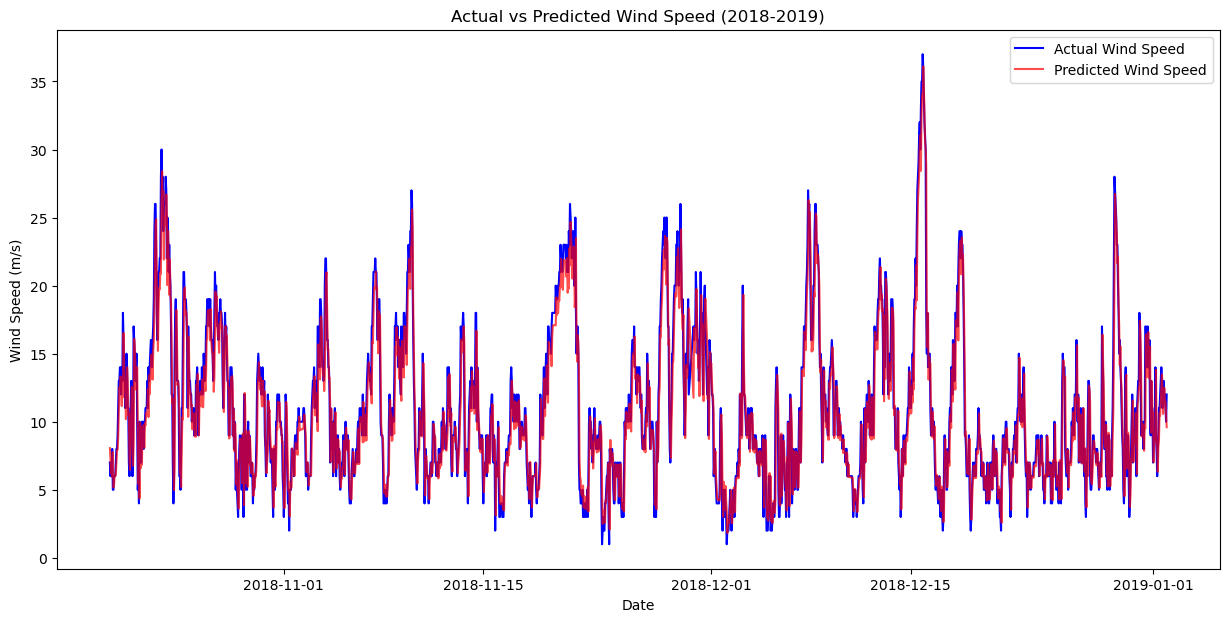

In [18]:
period_df = comparison_df['2018-01-01':'2019-01-01']
plt.figure(figsize=(15, 7))
plt.plot(period_df['mean_wind_speed'], label='Actual Wind Speed', color='blue')
plt.plot(period_df['Predicted Wind Speed'], label='Predicted Wind Speed', alpha=0.7, color='red')
plt.title('Actual vs Predicted Wind Speed (2018-2019)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.show()


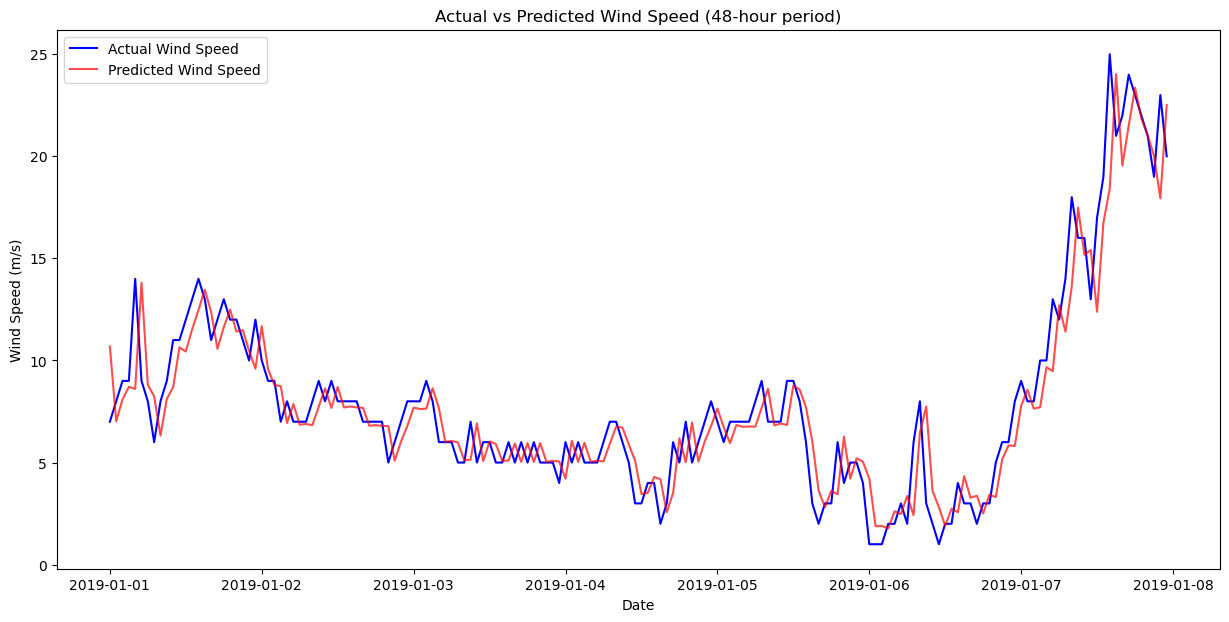

In [19]:
period_start = '2019-01-01 00:00:00'  
period_end = '2019-01-07 23:59:59'  
period_df = comparison_df.loc[period_start:period_end]
plt.figure(figsize=(15, 7))
plt.plot(period_df['mean_wind_speed'], label='Actual Wind Speed', color='blue')
plt.plot(period_df['Predicted Wind Speed'], label='Predicted Wind Speed', alpha=0.7, color='red')
plt.title('Actual vs Predicted Wind Speed (48-hour period)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.show()


In [20]:
#File path for Turbine Power Curve
file_path = "/Users/waleedjazzar/Desktop/Year 3 Uni/Final Year Files/Datasets/PowerCurves.xlsx"
# Excel into a pandas DataFrame
power_curves_df = pd.read_excel(file_path)
print(power_curves_df.head())


   Wind_speed  SG 8.0-167 DD  V164/9500  WT10000dd/190 SeaTitan
0         0.0              0          0                       0
1         0.5              0          0                       0
2         1.0              0          0                       0
3         1.5              0          0                       0
4         2.0              0          0                       0


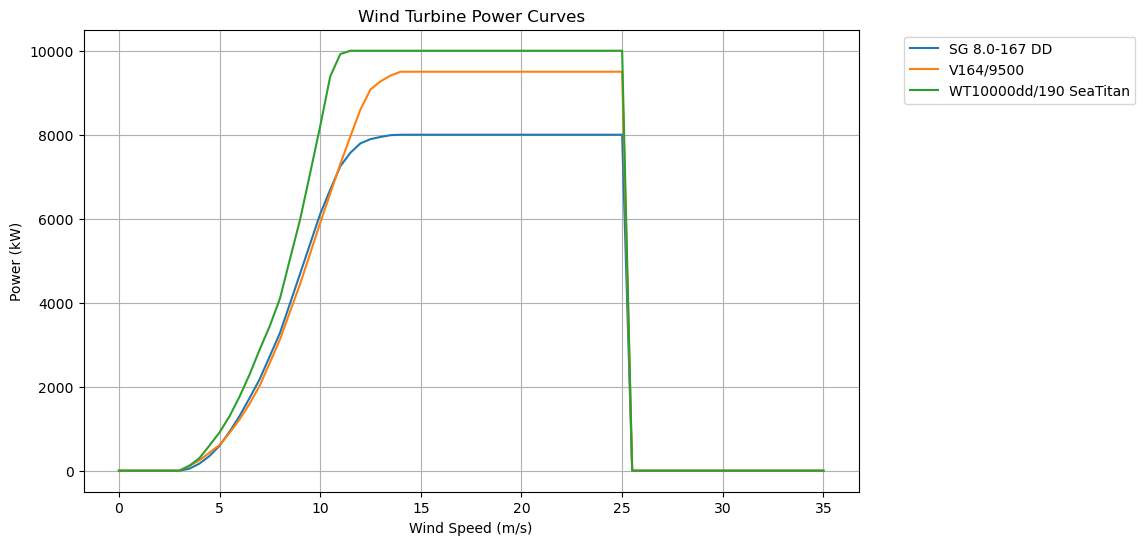

In [21]:
# Extract wind speed values
wind_speeds = power_curves_df['Wind_speed'].astype(float)
power_values = power_curves_df.drop(columns=['Wind_speed']).astype(float)
plt.figure(figsize=(10, 6))
for column in power_values.columns:
    plt.plot(wind_speeds, power_values[column], label=column)
plt.title('Wind Turbine Power Curves')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.grid(True)
plt.show()


In [22]:
#Constants
z_ref = 23  # Reference height (meters)
z_0 = 0.3  # Roughness length of the terrain (meters)
# Turbine models and heights
turbine_models = ['SG 8.0-167 DD', 'V164/9500', 'WT10000dd/190 SeaTitan']
heights = [87, 120, 125]
def logarithmic_wind_profile(wind_speed, height):
    return wind_speed * (np.log(height / z_0) / np.log(z_ref / z_0))

def calculate_hourly_kW(turbine_model, height, wind_speed):
    # Apply logarithmic wind profile adjustment
    wind_speed_adjusted = logarithmic_wind_profile(wind_speed, height)
    # Interpolate the power curve
    power_output = np.interp(wind_speed_adjusted, power_curves_df['Wind_speed'], power_curves_df[turbine_model])
    # 1 hour for time interval
    hourly_kW = power_output * 1  
    return hourly_kW

hourly_kW_df = pd.DataFrame()

# Calculate hourly kW generation for each turbine model and height
for turbine_model, height in zip(turbine_models, heights):
    predicted_wind_speeds = predicted_df['Predicted Wind Speed'].values
    adjusted_wind_speeds = [logarithmic_wind_profile(wind_speed, height) for wind_speed in predicted_wind_speeds]
    hourly_kW_df[f'Adjusted Wind Speed_{height}m'] = adjusted_wind_speeds
    hourly_kW = [calculate_hourly_kW(turbine_model, height, wind_speed) for wind_speed in predicted_wind_speeds]
    hourly_kW_df[f'Predicted Power Generated_{turbine_model.replace("/", "_").replace(" ", "_")}_{height}m'] = hourly_kW

# Combine the predicted wind times and speed with the hourly kW DataFrame
hourly_kW_df.insert(0, 'Date', predicted_df.index)
hourly_kW_df.insert(1, 'Predicted Wind Speed', predicted_df['Predicted Wind Speed'].values)
print(hourly_kW_df)
hourly_kW_df.to_excel('hourly_kW_df.xlsx', index=True)


                     Date  Predicted Wind Speed  Adjusted Wind Speed_87m  \
0     2018-10-19 19:00:00              8.058612                10.529259   
1     2018-10-19 20:00:00              7.272577                 9.502237   
2     2018-10-19 21:00:00              6.196115                 8.095748   
3     2018-10-19 22:00:00              7.024681                 9.178340   
4     2018-10-19 23:00:00              5.939479                 7.760432   
...                   ...                   ...                      ...   
15955 2020-12-10 11:00:00              8.586586                11.219102   
15956 2020-12-10 12:00:00              8.610055                11.249766   
15957 2020-12-10 13:00:00             11.740033                15.339346   
15958 2020-12-10 14:00:00             10.462464                13.670095   
15959 2020-12-10 15:00:00             11.578704                15.128556   

       Predicted Power Generated_SG_8.0-167_DD_87m  Adjusted Wind Speed_120m  \
0      

In [23]:
# Set the datetime column of hourly_kW_df as its index
hourly_kW_df.set_index('Date', inplace=True)

# Merge the two dataframes on their common index
combined_prediction = comparison_df.merge(hourly_kW_df, left_index=True, right_index=True)
combined_prediction.drop('Predicted Wind Speed_y', axis=1, inplace=True)

print(combined_prediction)


                     mean_wind_speed  Predicted Wind Speed_x  \
index                                                          
2018-10-19 19:00:00              7.0                8.058612   
2018-10-19 20:00:00              6.0                7.272577   
2018-10-19 21:00:00              7.0                6.196115   
2018-10-19 22:00:00              6.0                7.024681   
2018-10-19 23:00:00              8.0                5.939479   
...                              ...                     ...   
2020-12-10 11:00:00              9.0                8.586586   
2020-12-10 12:00:00             12.0                8.610055   
2020-12-10 13:00:00             11.0               11.740033   
2020-12-10 14:00:00             12.0               10.462464   
2020-12-10 15:00:00             12.0               11.578704   

                     Adjusted Wind Speed_87m  \
index                                          
2018-10-19 19:00:00                10.529259   
2018-10-19 20:00:00    

In [ ]:
print(combined_prediction.head())


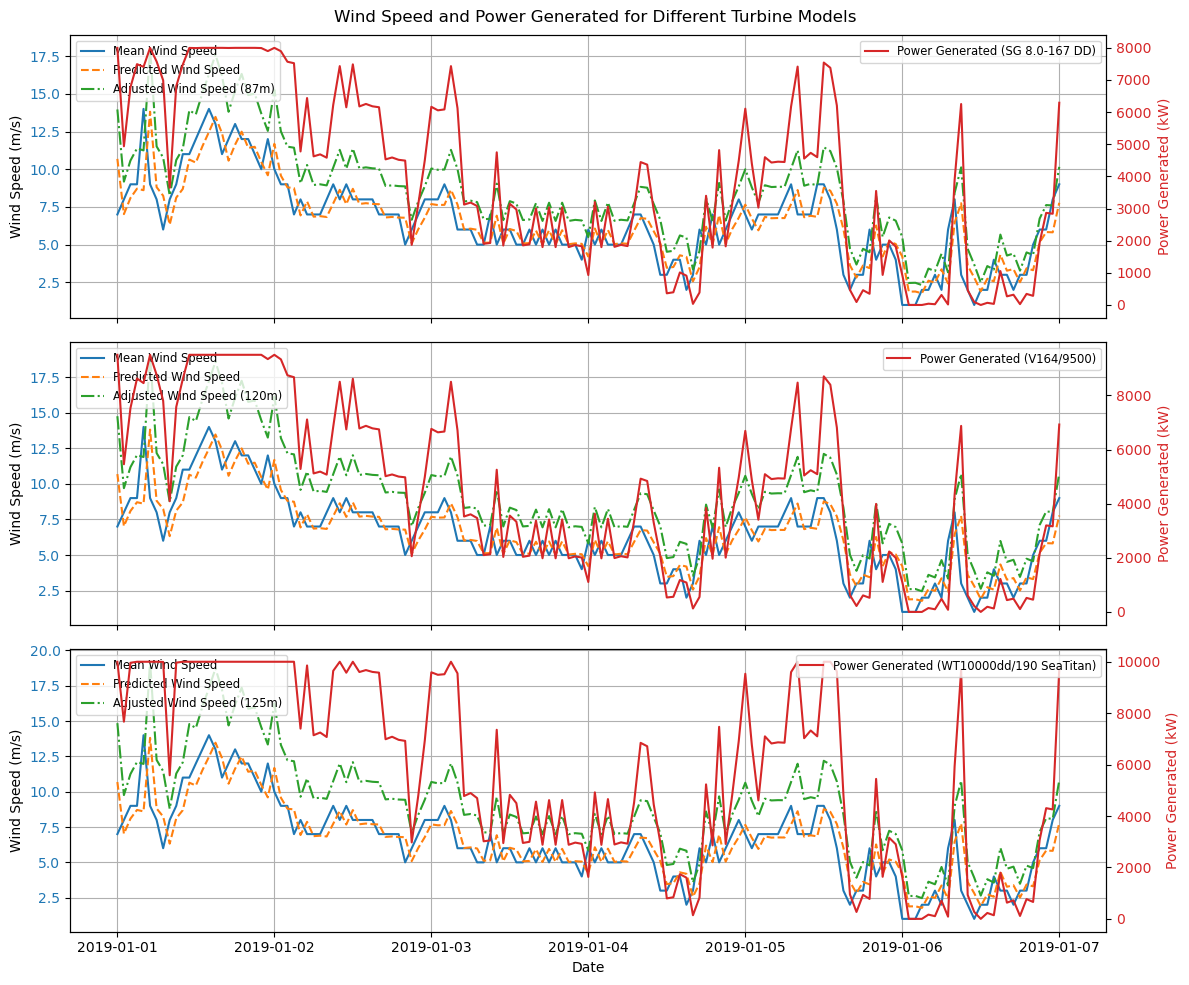

In [24]:
#Wind Speed and Generation 7 DAYS
start_date = '2019-01-01'
end_date = '2019-01-07'
filtered_combined_prediction = combined_prediction[(combined_prediction.index >= start_date) & (combined_prediction.index <= end_date)]
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
# Plot for SG 8.0-167 DD
axs[0].plot(filtered_combined_prediction.index, filtered_combined_prediction['mean_wind_speed'], color='tab:blue', label='Mean Wind Speed')
axs[0].plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Wind Speed_x'], color='tab:orange', linestyle='--', label='Predicted Wind Speed')
axs[0].plot(filtered_combined_prediction.index, filtered_combined_prediction['Adjusted Wind Speed_87m'], color='tab:green', linestyle='-.', label='Adjusted Wind Speed (87m)')
axs[0].set_ylabel('Wind Speed (m/s)')
axs[0].tick_params(axis='y', labelcolor='tab:blue')
axs[0].legend(loc='upper left', fontsize='small')
axs[0].grid(True)

axs2 = axs[0].twinx()
axs2.plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Power Generated_SG_8.0-167_DD_87m'], color='tab:red', label='Power Generated (SG 8.0-167 DD)')
axs2.set_ylabel('Power Generated (kW)', color='tab:red')
axs2.tick_params(axis='y', labelcolor='tab:red')
axs2.legend(loc='upper right', fontsize='small')

# Plot for V164/9500
axs[1].plot(filtered_combined_prediction.index, filtered_combined_prediction['mean_wind_speed'], color='tab:blue', label='Mean Wind Speed')
axs[1].plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Wind Speed_x'], color='tab:orange', linestyle='--', label='Predicted Wind Speed')
axs[1].plot(filtered_combined_prediction.index, filtered_combined_prediction['Adjusted Wind Speed_120m'], color='tab:green', linestyle='-.', label='Adjusted Wind Speed (120m)')
axs[1].set_ylabel('Wind Speed (m/s)')
axs[1].tick_params(axis='y', labelcolor='tab:blue')
axs[1].legend(loc='upper left', fontsize='small')
axs[1].grid(True)
axs3 = axs[1].twinx()
axs3.plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Power Generated_V164_9500_120m'], color='tab:red', label='Power Generated (V164/9500)')
axs3.set_ylabel('Power Generated (kW)', color='tab:red')
axs3.tick_params(axis='y', labelcolor='tab:red')
axs3.legend(loc='upper right', fontsize='small')
# Plot for WT10000dd/190 SeaTitan
axs[2].plot(filtered_combined_prediction.index, filtered_combined_prediction['mean_wind_speed'], color='tab:blue', label='Mean Wind Speed')
axs[2].plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Wind Speed_x'], color='tab:orange', linestyle='--', label='Predicted Wind Speed')
axs[2].plot(filtered_combined_prediction.index, filtered_combined_prediction['Adjusted Wind Speed_125m'], color='tab:green', linestyle='-.', label='Adjusted Wind Speed (125m)')
axs[2].set_ylabel('Wind Speed (m/s)')
axs[2].tick_params(axis='y', labelcolor='tab:blue')
axs[2].legend(loc='upper left', fontsize='small')
axs[2].grid(True)
axs4 = axs[2].twinx()
axs4.plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Power Generated_WT10000dd_190_SeaTitan_125m'], color='tab:red', label='Power Generated (WT10000dd/190 SeaTitan)')
axs4.set_ylabel('Power Generated (kW)', color='tab:red')
axs4.tick_params(axis='y', labelcolor='tab:red')
axs4.legend(loc='upper right', fontsize='small')
fig.suptitle('Wind Speed and Power Generated for Different Turbine Models')
axs[2].set_xlabel('Date')
plt.tight_layout()
plt.show()


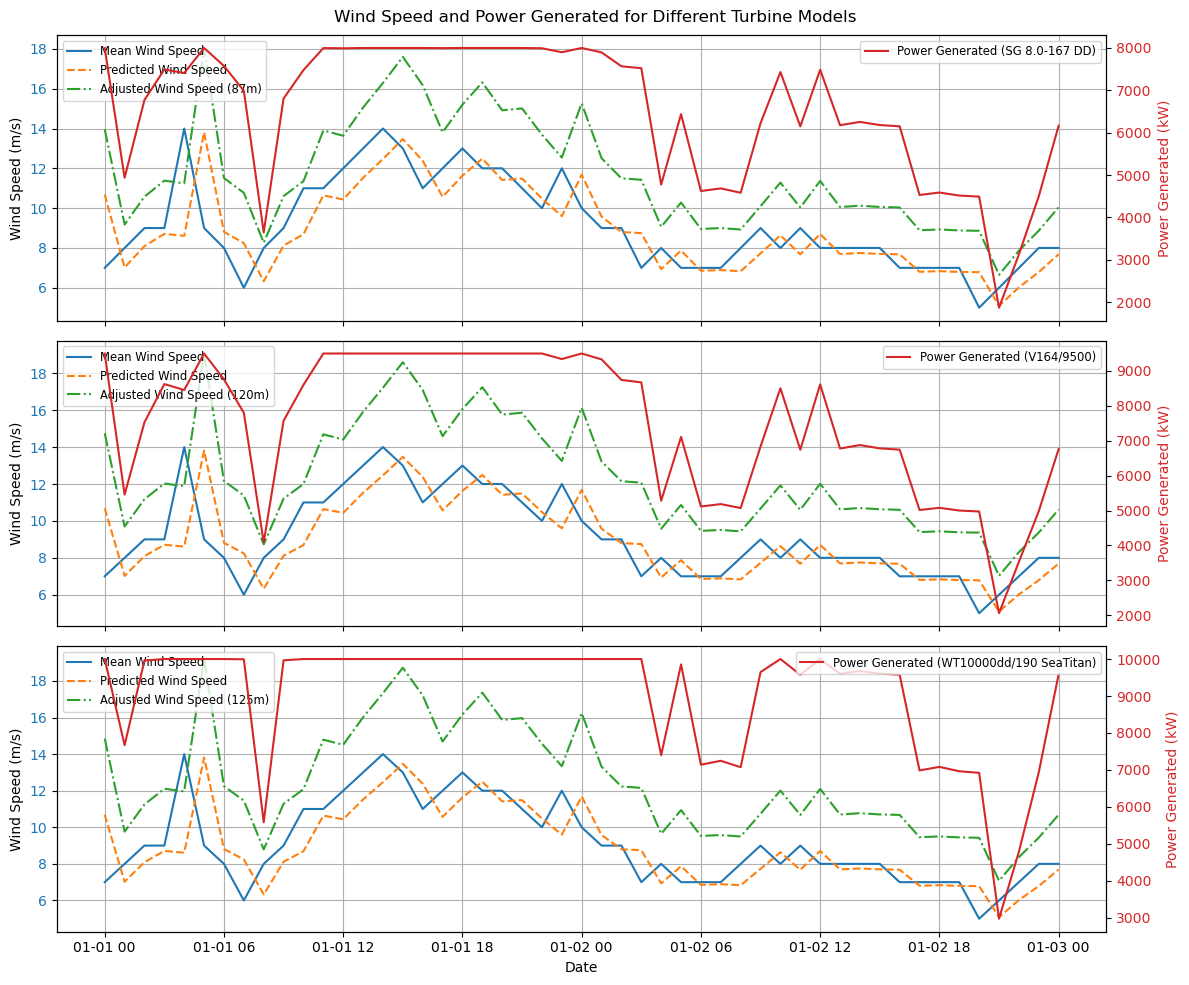

In [25]:
#Wind Speed and Generation 48 Hours
start_date = '2019-01-01'
end_date = '2019-01-03'
filtered_combined_prediction = combined_prediction[(combined_prediction.index >= start_date) & (combined_prediction.index <= end_date)]
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
# Plot for SG 8.0-167 DD
axs[0].plot(filtered_combined_prediction.index, filtered_combined_prediction['mean_wind_speed'], color='tab:blue', label='Mean Wind Speed')
axs[0].plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Wind Speed_x'], color='tab:orange', linestyle='--', label='Predicted Wind Speed')
axs[0].plot(filtered_combined_prediction.index, filtered_combined_prediction['Adjusted Wind Speed_87m'], color='tab:green', linestyle='-.', label='Adjusted Wind Speed (87m)')
axs[0].set_ylabel('Wind Speed (m/s)')
axs[0].tick_params(axis='y', labelcolor='tab:blue')
axs[0].legend(loc='upper left', fontsize='small')
axs[0].grid(True)
axs2 = axs[0].twinx()
axs2.plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Power Generated_SG_8.0-167_DD_87m'], color='tab:red', label='Power Generated (SG 8.0-167 DD)')
axs2.set_ylabel('Power Generated (kW)', color='tab:red')
axs2.tick_params(axis='y', labelcolor='tab:red')
axs2.legend(loc='upper right', fontsize='small')
# Plot for V164/9500
axs[1].plot(filtered_combined_prediction.index, filtered_combined_prediction['mean_wind_speed'], color='tab:blue', label='Mean Wind Speed')
axs[1].plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Wind Speed_x'], color='tab:orange', linestyle='--', label='Predicted Wind Speed')
axs[1].plot(filtered_combined_prediction.index, filtered_combined_prediction['Adjusted Wind Speed_120m'], color='tab:green', linestyle='-.', label='Adjusted Wind Speed (120m)')
axs[1].set_ylabel('Wind Speed (m/s)')
axs[1].tick_params(axis='y', labelcolor='tab:blue')
axs[1].legend(loc='upper left', fontsize='small')
axs[1].grid(True)
axs3 = axs[1].twinx()
axs3.plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Power Generated_V164_9500_120m'], color='tab:red', label='Power Generated (V164/9500)')
axs3.set_ylabel('Power Generated (kW)', color='tab:red')
axs3.tick_params(axis='y', labelcolor='tab:red')
axs3.legend(loc='upper right', fontsize='small')
# Plot for WT10000dd/190 SeaTitan
axs[2].plot(filtered_combined_prediction.index, filtered_combined_prediction['mean_wind_speed'], color='tab:blue', label='Mean Wind Speed')
axs[2].plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Wind Speed_x'], color='tab:orange', linestyle='--', label='Predicted Wind Speed')
axs[2].plot(filtered_combined_prediction.index, filtered_combined_prediction['Adjusted Wind Speed_125m'], color='tab:green', linestyle='-.', label='Adjusted Wind Speed (125m)')
axs[2].set_ylabel('Wind Speed (m/s)')
axs[2].tick_params(axis='y', labelcolor='tab:blue')
axs[2].legend(loc='upper left', fontsize='small')
axs[2].grid(True)
axs4 = axs[2].twinx()
axs4.plot(filtered_combined_prediction.index, filtered_combined_prediction['Predicted Power Generated_WT10000dd_190_SeaTitan_125m'], color='tab:red', label='Power Generated (WT10000dd/190 SeaTitan)')
axs4.set_ylabel('Power Generated (kW)', color='tab:red')
axs4.tick_params(axis='y', labelcolor='tab:red')
axs4.legend(loc='upper right', fontsize='small')
fig.suptitle('Wind Speed and Power Generated for Different Turbine Models')
axs[2].set_xlabel('Date')
plt.tight_layout()
plt.show()


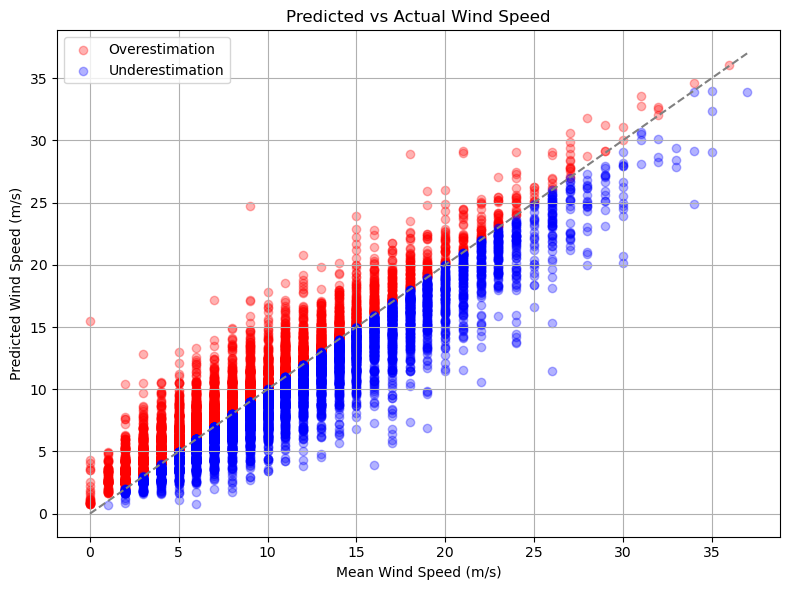

In [26]:
# mean wind speed and predicted wind speed
mean_wind_speed = combined_prediction['mean_wind_speed']
predicted_wind_speed = combined_prediction['Predicted Wind Speed_x']
overestimation_mask = predicted_wind_speed > mean_wind_speed
underestimation_mask = predicted_wind_speed <= mean_wind_speed
plt.figure(figsize=(8, 6))
plt.scatter(mean_wind_speed[overestimation_mask], predicted_wind_speed[overestimation_mask], color='red', alpha=0.3, label='Overestimation')
plt.scatter(mean_wind_speed[underestimation_mask], predicted_wind_speed[underestimation_mask], color='blue', alpha=0.3, label='Underestimation')
plt.title('Predicted vs Actual Wind Speed')
plt.xlabel('Mean Wind Speed (m/s)')
plt.ylabel('Predicted Wind Speed (m/s)')
plt.plot([min(mean_wind_speed), max(mean_wind_speed)], [min(mean_wind_speed), max(mean_wind_speed)], color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


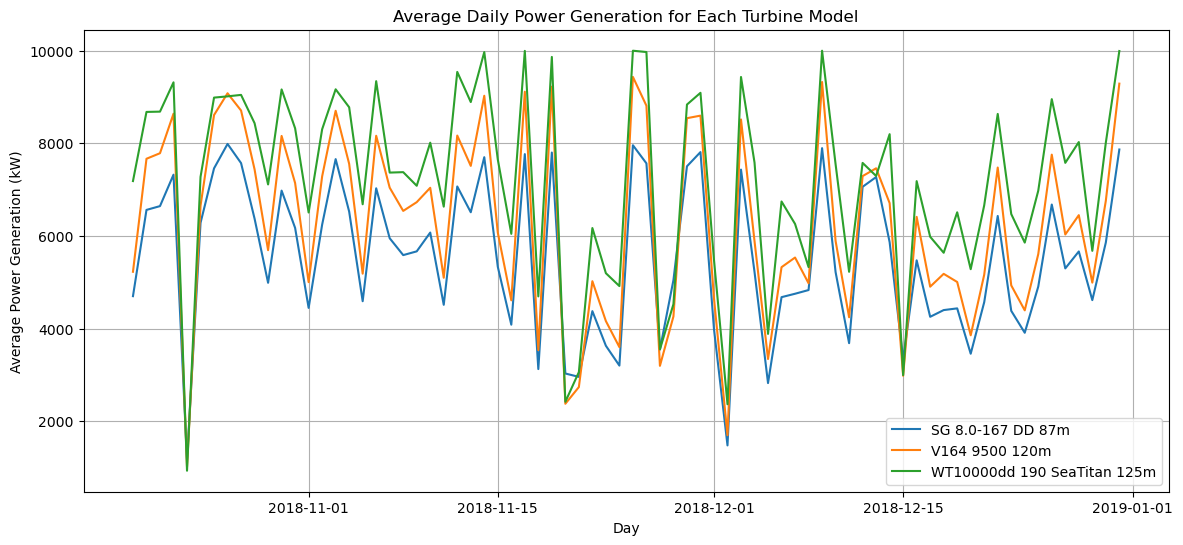

In [27]:
#Average Daily Power Generation For Each Turbine
start_date = '2018-01-01'
end_date = '2018-12-31'
combined_prediction.index = pd.to_datetime(combined_prediction.index)
daily_avg_SG = combined_prediction['Predicted Power Generated_SG_8.0-167_DD_87m'].resample('D').mean()
daily_avg_V164 = combined_prediction['Predicted Power Generated_V164_9500_120m'].resample('D').mean()
daily_avg_WT10000dd = combined_prediction['Predicted Power Generated_WT10000dd_190_SeaTitan_125m'].resample('D').mean()
daily_avg_SG_filtered = daily_avg_SG[(daily_avg_SG.index >= start_date) & (daily_avg_SG.index <= end_date)]
daily_avg_V164_filtered = daily_avg_V164[(daily_avg_V164.index >= start_date) & (daily_avg_V164.index <= end_date)]
daily_avg_WT10000dd_filtered = daily_avg_WT10000dd[(daily_avg_WT10000dd.index >= start_date) & (daily_avg_WT10000dd.index <= end_date)]
plt.figure(figsize=(14, 6))
plt.plot(daily_avg_SG_filtered.index, daily_avg_SG_filtered, label='SG 8.0-167 DD 87m')
plt.plot(daily_avg_V164_filtered.index, daily_avg_V164_filtered, label='V164 9500 120m')
plt.plot(daily_avg_WT10000dd_filtered.index, daily_avg_WT10000dd_filtered, label='WT10000dd 190 SeaTitan 125m')
plt.title('Average Daily Power Generation for Each Turbine Model')
plt.xlabel('Day')
plt.ylabel('Average Power Generation (kW)')
plt.legend()
plt.grid(True)
plt.show()


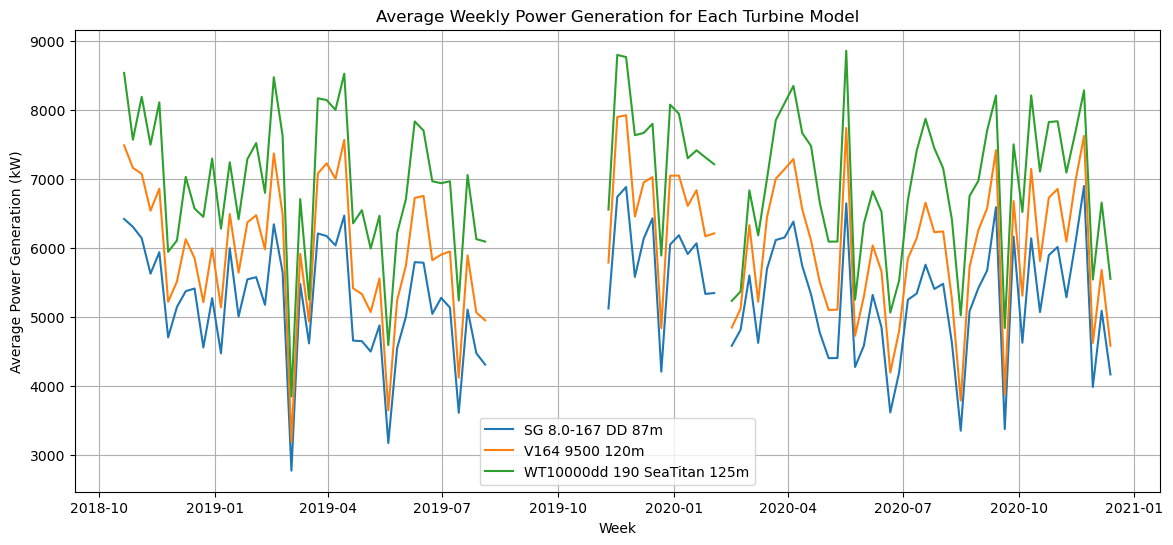

In [28]:

#Average Weekly Power Generation For Each Turbine
start_date = '2016-01-01'
end_date = '2020-12-31'
combined_prediction.index = pd.to_datetime(combined_prediction.index)
weekly_avg_SG = combined_prediction['Predicted Power Generated_SG_8.0-167_DD_87m'].resample('W').mean()
weekly_avg_V164 = combined_prediction['Predicted Power Generated_V164_9500_120m'].resample('W').mean()
weekly_avg_WT10000dd = combined_prediction['Predicted Power Generated_WT10000dd_190_SeaTitan_125m'].resample('W').mean()
weekly_avg_SG_filtered = weekly_avg_SG[(weekly_avg_SG.index >= start_date) & (weekly_avg_SG.index <= end_date)]
weekly_avg_V164_filtered = weekly_avg_V164[(weekly_avg_V164.index >= start_date) & (weekly_avg_V164.index <= end_date)]
weekly_avg_WT10000dd_filtered = weekly_avg_WT10000dd[(weekly_avg_WT10000dd.index >= start_date) & (weekly_avg_WT10000dd.index <= end_date)]
plt.figure(figsize=(14, 6))
plt.plot(weekly_avg_SG_filtered.index, weekly_avg_SG_filtered, label='SG 8.0-167 DD 87m')
plt.plot(weekly_avg_V164_filtered.index, weekly_avg_V164_filtered, label='V164 9500 120m')
plt.plot(weekly_avg_WT10000dd_filtered.index, weekly_avg_WT10000dd_filtered, label='WT10000dd 190 SeaTitan 125m')
plt.title('Average Weekly Power Generation for Each Turbine Model')
plt.xlabel('Week')
plt.ylabel('Average Power Generation (kW)')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
# Splitting the data into train and test sets
train_size = int(len(Wind_Clean['mean_wind_speed']) * 0.6)
train_data = Wind_Clean['mean_wind_speed'][:train_size]
test_data = Wind_Clean['mean_wind_speed'][train_size:]
# ARIMA Model
arima_model = ARIMA(train_data, order=(5,1,0))
arima_result = arima_model.fit()
arima_predicted = arima_result.forecast(steps=len(test_data))
arima_mse = mean_squared_error(test_data, arima_predicted)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test_data, arima_predicted)
arima_r2 = r2_score(test_data, arima_predicted)
print(f'ARIMA Test MSE: {arima_mse}')
print(f'ARIMA Test RMSE: {arima_rmse}')
print(f'ARIMA Test MAE: {arima_mae}')
print(f'ARIMA Test R2: {arima_r2}')


/Users/waleedjazzar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/waleedjazzar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/waleedjazzar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA Test MSE: 40.353012774065476
ARIMA Test RMSE: 6.352402126287777
ARIMA Test MAE: 4.64319737022636
ARIMA Test R2: -0.4634218097369698


/Users/waleedjazzar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/waleedjazzar/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [30]:
# Splitting the data into train and test sets
train_size = int(len(Wind_Clean['mean_wind_speed']) * 0.6)
train_data = Wind_Clean['mean_wind_speed'][:train_size]
test_data = Wind_Clean['mean_wind_speed'][train_size:]
# Create and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(train_data.values.reshape(-1, 1), train_data.index)

# Predict
rf_predicted = rf_model.predict(test_data.values.reshape(-1, 1))

# Evaluation
rf_mse = mean_squared_error(test_data, rf_predicted)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(test_data, rf_predicted)
rf_r2 = r2_score(test_data, rf_predicted)

print(f'Random Forest Test MSE: {rf_mse}')
print(f'Random Forest Test RMSE: {rf_rmse}')
print(f'Random Forest Test MAE: {rf_mae}')
print(f'Random Forest Test R2: {rf_r2}')


Random Forest Test MSE: 2.2372849592073668e+36
Random Forest Test RMSE: 1.4957556482284687e+18
Random Forest Test MAE: 1.49575476945749e+18
Random Forest Test R2: -8.113623689591715e+34


In [ ]:
print(arima_predicted)